In [5]:
import os
import sys

WDIR = '/home/jdv/code/activmask/activmask'
sys.path.insert(0, os.path.dirname(WDIR))
os.chdir(WDIR)

from activmask.datasets.msdd import HeartMSDDataset, LiverMSDDataset, PancreasMSDDataset, ColonMSDDataset
from activmask.datasets.synth import SyntheticDataset
from activmask.datasets.xray import JointDataset
from activmask.models.loss import compare_activations, get_grad_contrast
from activmask.models.resnet import ResNetModel
from collections import OrderedDict
from copy import copy
from glob import glob
from skimage import io
from textwrap import wrap
import argparse
import datetime
import itertools
import logging
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import pprint
import random
import seaborn as sns
import time
import torch
import torch.nn as nn
import yaml

%matplotlib inline
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")

In [6]:
# GLOBALS
SEEDS=[1234, 3232, 3221, 9856, 1290, 1987, 3200, 6400, 8888, 451]
RESULTS_DIR = "/home/jdv/code/activmask/results"
LAST_MODEL_NAME = "last_model_1234.pth.tar"
BEST_MODEL_NAME = "best_model_1234.pth.tar"

Functions
---------------

In [7]:
def load_model(model_path):
    """ Loads a checkpointed model to the CPU. 
    Note: this is very sensitive to the path. Check the current directory
    is set correctly in the import statements if you get 'module not found'
    errors.
    """
    return torch.load(model_path, map_location='cpu')


def get_metrics(path, best=False, last=False):
    """
    Loads the outputs of training, if best, only 
    keeps best epoch for each dataframe.
    """

    def _convert_dtype(dictionary):
        """
        Converts all entries in all subdictionaries to be of datatype
        [int, float, str]. All non-matching entries are converted to str.
        """
        TYPES = [float, int, str, np.float32, np.float64, bool]
    
        for d in dictionary:
            if type(d) == dict:
                d = _convert_dtype(d)
            else:
                if type(dictionary[d]) not in TYPES:
                    dictionary[d] = str(dictionary[d])
    
    assert not all([best, last])
    
    all_df = [] 
    for f in glob(os.path.join(path, "*/stats_*.pkl")):
        d = pickle.load(open(f,"rb"))
        _convert_dtype(d)
        d = pd.DataFrame.from_dict(d)
                
        if best:
            # Offset by 1 because of a bug in how "best" stats are stored.
            # Data at best_epoch are all actually the second-best epoch.
            best_epoch = d.iloc[-1]['best_epoch']
            d = d[d['this_epoch'] == best_epoch]
        elif last:
            last_epoch = d.iloc[-1]['this_epoch']
            d = d[d['this_epoch'] == last_epoch]

        all_df.append(d)

    return pd.concat(all_df)


def df_cleaner(df, keep=['auc', 'seed'], remove=[], verbose=False):
    """Selects the columns of the metrics dataframe to keep."""
    for col in df.columns:
        if not any([string in col for string in keep]):
            del df[col]
        elif any([string in col for string in remove]):
            del df[col]
            
    # Experiment name is determined by the configuration file used.
    experiments = df.experiment_name.unique()

    if verbose:
        print("resulting df \nshape={} tracking {} experiments, \nexperiments={}".format(
            df.shape, len(experiments), df.experiment_name.unique()))

    return(df)


def df_experiment_filter(df, name):
    return df[df['experiment_name'].str.contains(name)]


def get_performance_metrics(path, best=False):
    KEEP = ["auc", "best", "seed", "epoch", "name", "maxmasks"]
    return df_cleaner(get_metrics(path, best=best), keep=KEEP)


def get_best_hyperparameters(path):
    KEEP = ['name', 'blur', 'actdiff', 'disc', 'gradmask', 'lr', 'type', 'acts']
    FILTER = ['loss']
    df =  df_cleaner(get_metrics(path, best=True), keep=KEEP, remove=FILTER)
    df =  df[df['experiment_name'].str.contains('search')]
    return df
    

def get_last_results_at_epoch(df, epoch, sig_digits=3):
    """Get the train/test/valid AUC at the final, not best, epoch."""
    #groups = ['experiment_name', 'actdiff_lambda', 'recon_lambda']
    fmt_str = "${0:." + str(sig_digits) + "f}\pm{1:." + str(sig_digits) + "f}$"
    
    groups = ['experiment_name']
    cols = ['train_auc', 'valid_auc', 'best_epoch']
    
    df = get_results_at_epoch(df, epoch, groups, cols)
    df = df.round(sig_digits)
    
    results = [] 
    for a, b in zip(df["train_auc"], df["train_auc_std"]):
        results.append(fmt_str.format(a, b))
    df['train_auc'] = results 
    df = df.drop(['train_auc_std'], axis=1)

    results = [] 
    for a, b in zip(df["valid_auc"], df["valid_auc_std"]):
        results.append(fmt_str.format(a, b))
    df['valid_auc'] = results 
    df = df.drop(['valid_auc_std'], axis=1)
    
    results = [] 
    for a, b in zip(df["best_epoch"], df["best_epoch_std"]):
        results.append(fmt_str.format(a, b))
    df['best_epoch'] = results 
    df = df.drop(['best_epoch_std'], axis=1)
    
    return df


def make_results_table(dfs, sig_digits=3, count=False):
    """
    Merge the best test results for all dataframes submitted. 
    Used to make a results table across datasets.
    """
    
    fmt_str = "${0:." + str(sig_digits) + "f}\pm{1:." + str(sig_digits) + "f}$"
    for i, df in enumerate(dfs):
        tmp_df = copy(df)
        
        # Strip the dataset name out of the experiment name.        
        name = tmp_df['experiment_name'].iloc[0].split('_')[0]
        tmp_df['experiment_name'] = tmp_df['experiment_name'].str.replace('{}_'.format(name), '')
        
        # Reformat the table.
        tmp_df = get_test_results(tmp_df, count=count)
        tmp_df = tmp_df.round(sig_digits)

        # Merge mean+/-std into a single column with the experiment name.
        results = [] 
        for a, b in zip(tmp_df["best_test_auc"], tmp_df["best_test_auc_std"]):
            results.append(fmt_str.format(a, b))
        tmp_df['test_auc_{}'.format(name)] = results 
        tmp_df = tmp_df.drop(['best_test_auc', 'best_test_auc_std'], axis=1)

        print(tmp_df)
        
        # Merge the experiments.
        if i == 0:
            final_df = copy(tmp_df)
        else:
            final_df = pd.merge(final_df, tmp_df, on='experiment_name')
    
    return final_df


def get_results(df, groups, cols, count=False, mode='mean'):
    """
    Shows a reduced form of the table with mean and std values 
    over experiments.
    """
    df_tmp = df.groupby(groups)[cols]
    if mode == 'mean':
        df = df_tmp.mean().join(df_tmp.std(),rsuffix='_std')
    elif mode == 'max':
        df = df_tmp.max().join(df_tmp.std(),rsuffix='_std')
    if count:
        df = df.join(df_tmp.count(), rsuffix='_count')
                                                                        
    return df


def get_test_results(df, count=False):
    """Get the test results at the best epoch."""
    groups = ['experiment_name']
    cols = ['best_test_score']
    return get_results(df, groups, cols, count=count, mode='mean')


def seed_finder(df, experiment_name):
    test = df[df.epoch == EPOCH]
    test = test[test['experiment_name'] == experiment_name]

    for seed in SEEDS:
        if seed not in np.array(test['seed']):
            print("{} missing {}".format(experiment_name, seed))

# Plotting

In [8]:
def render_salience_maps(text, idx, sample, sample_blur, modelz, exp_name, blur):

    fig, ax = plt.subplots(nrows=3, ncols=5, figsize=(15, 8), dpi=150, gridspec_kw={'hspace': 0.15, 'wspace': 0.01})
    fig.subplots_adjust(wspace=0.0)
    for a in ax:
        for aa in a:
            aa.axis('off')

    x, target, use_mask = sample
    img = x[0][0].cpu().numpy()
    #img = img / np.max(img)
    seg = x[1][0].cpu().numpy() 
    seg_blur = sample_blur[0][1][0]
    
    x_var = torch.autograd.Variable(x[0].unsqueeze(0),requires_grad=True)
    
    ax[0,0].set_title(str(idx) + "Image")
    ax[0,0].imshow(img, interpolation='none', cmap='Greys_r')
    ax[0,0].axis('off')    
    
    ax[0,1].set_title('Pathology + Mask (blur={})'.format(blur))
    ax[0,1].imshow((1-seg_blur).numpy()+(1-seg), cmap="Greys_r", interpolation='none')
    ax[0,1].axis('on')
    ax[0,1].get_xaxis().set_ticks([])
    ax[0,1].get_yaxis().set_ticks([])

    my_cmap = plt.cm.jet
    my_cmap.set_under('k', alpha=0)
    
    name = "UNet Masked"
    model = modelz[name]
    y_prime, x_prime = model(x_var)
    gradmask = get_gradmask_loss(x_var, y_prime, resnet, torch.tensor(1.),
                                 "contrast").detach().cpu().numpy()[0][0]
    gradmask *= (gradmask>np.percentile(gradmask,90))
    ax[2,4].set_title(name)
    ax[2,4].imshow(img, interpolation='none', cmap='Greys_r')
    ax[2,4].imshow(gradmask, interpolation='none', cmap=my_cmap, clim=[0.000001, gradmask.max()])
    ax[2,4].axis('off')  
    ax[1,4].set_title("Unet Masked Recon")
    ax[1,4].imshow(x_prime.detach().numpy()[0][0], interpolation='none', cmap='Greys_r')
    ax[1,4].axis('off')  
    
    name = "UNet Baseline"
    model = modelz[name]
    y_prime, x_prime = model(x_var)
    gradmask = get_gradmask_loss(x_var, y_prime, resnet, torch.tensor(1.),
                                 "contrast").detach().cpu().numpy()[0][0]
    gradmask *= (gradmask>np.percentile(gradmask,90))
    ax[2,0].set_title(name)
    ax[2,0].imshow(img, interpolation='none', cmap='Greys_r')
    ax[2,0].imshow(gradmask, interpolation='none', cmap=my_cmap, clim=[0.000001, gradmask.max()])
    ax[2,0].axis('off')
    ax[0,4].set_title("Unet Baseline Recon")
    ax[0,4].imshow(x_prime.detach().numpy()[0][0], interpolation='none', cmap='Greys_r')
    ax[0,4].axis('off')  
    
    
    name = "Resnet Baseline"
    model = modelz[name]
    y_prime, x_prime = model(x_var)
    gradmask = get_gradmask_loss(x_var, y_prime, resnet, torch.tensor(1.),
                                 "contrast").detach().cpu().numpy()[0][0]
    gradmask *= (gradmask>np.percentile(gradmask,90))
    ax[1,0].set_title(name)
    ax[1,0].imshow(img, interpolation='none', cmap='Greys_r')
    ax[1,0].imshow(gradmask, interpolation='none', cmap=my_cmap, clim=[0.000001, gradmask.max()])
    ax[1,0].axis('off')  
    
    name = "Resnet ActDiff"
    model = modelz[name]
    y_prime, x_prime = model(x_var)
    gradmask = get_gradmask_loss(x_var, y_prime, resnet, torch.tensor(1.),
                                 "contrast").detach().cpu().numpy()[0][0]
    gradmask *= (gradmask>np.percentile(gradmask,90))
    ax[1,1].set_title(name)
    ax[1,1].imshow(img, interpolation='none', cmap='Greys_r')
    ax[1,1].imshow(gradmask, interpolation='none', cmap=my_cmap, clim=[0.000001, gradmask.max()])
    ax[1,1].axis('off')
    
    name = "UNet ActDiff"
    model = modelz[name]
    y_prime, x_prime = model(x_var)
    gradmask = get_gradmask_loss(x_var, y_prime, resnet, torch.tensor(1.),
                                 "contrast").detach().cpu().numpy()[0][0]
    gradmask *= (gradmask>np.percentile(gradmask,90))
    ax[2,1].set_title(name)
    ax[2,1].imshow(img, interpolation='none', cmap='Greys_r')
    ax[2,1].imshow(gradmask, interpolation='none', cmap=my_cmap, clim=[0.000001, gradmask.max()])
    ax[2,1].axis('off')
    
    name = "Resnet Gradmask"
    model = modelz[name]
    y_prime, x_prime = model(x_var)
    gradmask = get_gradmask_loss(x_var, y_prime, resnet, torch.tensor(1.),
                                 "contrast").detach().cpu().numpy()[0][0]
    gradmask *= (gradmask>np.percentile(gradmask,90))
    ax[1,2].set_title(name)
    ax[1,2].imshow(img, interpolation='none', cmap='Greys_r')
    ax[1,2].imshow(gradmask, interpolation='none', cmap=my_cmap, clim=[0.000001, gradmask.max()])
    ax[1,2].axis('off')
    
    name = "UNet Gradmask"
    model = modelz[name]
    y_prime, x_prime = model(x_var)
    gradmask = get_gradmask_loss(x_var, y_prime, resnet, torch.tensor(1.),
                                 "contrast").detach().cpu().numpy()[0][0]
    gradmask *= (gradmask>np.percentile(gradmask,90))
    ax[2,2].set_title(name)
    ax[2,2].imshow(img, interpolation='none', cmap='Greys_r')
    ax[2,2].imshow(gradmask, interpolation='none', cmap=my_cmap, clim=[0.000001, gradmask.max()])
    ax[2,2].axis('off')
    
    name = "Resnet ActGrad"
    model = modelz[name]
    y_prime, x_prime = model(x_var)
    gradmask = get_gradmask_loss(x_var, y_prime, resnet, torch.tensor(1.),
                                 "contrast").detach().cpu().numpy()[0][0]
    gradmask *= (gradmask>np.percentile(gradmask,90))
    ax[1,3].set_title(name)
    ax[1,3].imshow(img, interpolation='none', cmap='Greys_r')
    ax[1,3].imshow(gradmask, interpolation='none', cmap=my_cmap, clim=[0.000001, gradmask.max()])
    ax[1,3].axis('off')
    
    name = "UNet ActGrad"
    model = modelz[name]
    y_prime, x_prime = model(x_var)
    gradmask = get_gradmask_loss(x_var, y_prime, resnet, torch.tensor(1.),
                                 "contrast").detach().cpu().numpy()[0][0]
    gradmask *= (gradmask>np.percentile(gradmask,90))
    ax[2,3].set_title(name)
    ax[2,3].imshow(img, interpolation='none', cmap='Greys_r')
    ax[2,3].imshow(gradmask, interpolation='none', cmap=my_cmap, clim=[0.000001, gradmask.max()])
    ax[2,3].axis('off')
    
    plt.tight_layout()
    plt.show()

    
def render_salicnece_xray(text, i, sample, models_list, exp_name):
    fig, (ax0, ax1, ax2, ax3, ax4, ax5) = plt.subplots(nrows=1, ncols=6,
                                             figsize=(15, 7), dpi=200)
    x, target, use_mask = sample
    #x = torch.tensor(x)
    x_var = torch.autograd.Variable(x[0].unsqueeze(0),
        requires_grad=True).float()
#     if torch.cuda.is_available():
#         x_var = x_var.cuda()
#         cnn = cnn.cuda()
#         resnet = resnet.cuda()
#         unet = unet.cuda()

    ax0.set_title(str(i) + " Input Image")
    img = x[0][0].cpu().numpy()
    img = img / np.max(img)  # Scales the input image so that the maximum=1.
    seg = x[1][0].cpu().numpy() #* 0.5  # Makes mask bright, but not too bright.
    ax0.imshow(img, interpolation='none', cmap='Greys_r')
    ax0.axis('off')
    
    ax1.set_title("Mask")
    ax1.imshow(1-seg, cmap="Greys_r", interpolation='none')
    ax1.get_xaxis().set_ticks([])
    ax1.get_yaxis().set_ticks([])

    ax2.set_title(models_list[0][0])
    this_model = models_list[0][1]
    y_prime, x_prime = this_model(x_var)
    gradmask = get_gradmask_loss(x_var, y_prime, this_model, torch.tensor(1.),
                                 "contrast").detach().cpu().numpy()[0][0]
    ax2.imshow(np.abs(gradmask), cmap="jet", interpolation='none')
    ax2.axis('off')
    
    ax3.set_title(models_list[1][0])
    this_model = models_list[1][1]
    y_prime, x_prime = this_model(x_var)
    gradmask = get_gradmask_loss(x_var, y_prime, this_model, torch.tensor(1.),
                                 "contrast").detach().cpu().numpy()[0][0]
    ax3.imshow(np.abs(gradmask), cmap="jet", interpolation='none')
    ax3.axis('off')
    
    ax4.set_title(models_list[2][0])
    this_model = models_list[2][1]
    y_prime, x_prime = this_model(x_var)
    gradmask = get_gradmask_loss(x_var, y_prime, this_model, torch.tensor(1.),
                                 "contrast").detach().cpu().numpy()[0][0]
    ax4.imshow(np.abs(gradmask), cmap="jet", interpolation='none')
    ax4.axis('off')

    ax5.set_title("UNet Reconstruction")
    # Fails for models that output a nonsense reconstruction (CNN, ResNet).
    if isinstance(x_prime, torch.Tensor):
        ax5.imshow(x_prime[0][0].detach().cpu().numpy(),
                   interpolation='none', cmap='Greys_r')
        ax5.axis('off')
    else:
        ax5.remove()

    plt.tight_layout()
    plt.show()

    
def plot_search_space(pattern, title, seed):
    """
    Generates skopt search results for a visualization of the 
    difficulty of tuning different models.
    """
    
    def get_opt(state):
        """Loads a checkpoint, extracting the skopt state."""
        with open(state, 'rb') as f:
            d = torch.load(f)
        return d['hp_opt']


    def get_search_results(searches, seed):
        """
        Given a list of folders, retrieve the skopt 
        checkpoint and load search results.
        """
        search_results = OrderedDict()
        NAME_MAP = {'resnet': 'Unregularized',
                   'resnet_actdiff': 'Actdiff',
                   'resnet_clfmasked': 'Classify Masked',
                   'resnet_discriminator': 'Discriminator',
                   'resnet_gradmask': 'Gradmask'}
    
        searches.sort()
        for search in searches:
            state_file = os.path.join(search, 'skopt_checkpoint_{}.pth.tar'.format(seed))
            hp_opt = get_opt(state_file)
        
            name = '_'.join(os.path.basename(os.path.dirname(state_file)).split('_')[1:])
            search_results[NAME_MAP[name]] = {'x': hp_opt.Xi, 'y': np.abs(hp_opt.yi)}
    
        return search_results


    def label(x, color, label):
        """Labels an axes"""
        ax = plt.gca()
        ax.text(0, .2, label, fontweight="bold", color=color,
                ha="left", va="center", transform=ax.transAxes)
 
    def fix_scores(scores):
        """
        Adds a small amount of non-negative noise to all scores so that 
        constant results (like all-0) are rendered.
        """
        EPS = 0.0000001
        add_noise = lambda x: x + (np.random.random(1) * EPS)
        idx = np.where(scores <= 0.99)[0]
        for i in idx:
            scores[i] = add_noise(scores[i])

        assert np.max(scores) <= 1
        assert np.min(scores) >= 0
            
        return scores

    SCORE_NAME = "AUC"

    searches = glob('{}_*'.format(pattern))
    search_results = get_search_results(searches, seed)
    
    # Make a long-form dataframe.
    scores, experiment_names = [], []
    
    for experiment, result in search_results.items():
        aucs = np.array(result['y'])
        names = np.array([experiment] * len(aucs))

        scores.append(aucs)
        experiment_names.append(names)
    
    scores = fix_scores(np.concatenate(scores))
    experiment_names = np.concatenate(experiment_names)
    df = pd.DataFrame({SCORE_NAME: scores, 'name': experiment_names})

    # Plotting
    sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

    pal = sns.cubehelix_palette(len(np.unique(experiment_names)), rot=-.25, light=.5)
    g = sns.FacetGrid(df, row="name", hue='name', aspect=15, height=0.75, palette=pal)
    
    g.map(sns.kdeplot, SCORE_NAME, clip_on=False, shade=True, alpha=1, lw=1.5, bw=.002)
    #g.map(sns.kdeplot, "auc", clip_on=False, color="w", lw=2, bw=.002)
    g.map(plt.axhline, y=0, lw=0.1, clip_on=False)
    g.map(label, SCORE_NAME)

    g.fig.subplots_adjust(hspace=-.25)
    g.set_titles("")
    g.fig.suptitle(title)
    g.set(yticks=[])
    g.despine(bottom=True, left=True)

    plt.show()

# Collect Data from Disk

In [9]:
# Contains **all* results.
df_hparams = get_best_hyperparameters(RESULTS_DIR)
df_performance = get_performance_metrics(RESULTS_DIR, best=True)

# Collect the seed results experiments.
df_seeds = []
for pattern in ['synth-seeds_', 'livermsd-seeds_', 'pancreasmsd-seeds_', 'cardiacmsd-seeds_', 'colonmsd-seeds_']:
    df_seeds.append(df_experiment_filter(df_performance, pattern))

df_seeds = pd.concat(df_seeds, axis=0)

# Hyperparameter Search Results

In [10]:
_df = df_hparams.groupby(['experiment_name']).first()
_df

,dataset_train_ColonMSDDataset_blur,dataset_train_HeartMSDDataset_blur,dataset_train_LiverMSDDataset_blur,dataset_train_PancreasMSDDataset_blur,dataset_train_SyntheticDataset_blur,model_ResNetModel_actdiff_lamb,model_ResNetModel_disc_iter,model_ResNetModel_disc_lamb,model_ResNetModel_disc_lr,model_ResNetModel_gradmask_lamb,model_ResNetModel_resnet_type,model_ResNetModel_save_acts,optimizer_Adam_lr
experiment_name,,,,,,,,,,,,,
cardiacmsd-search_resnet,NaN,2.000000,NaN,NaN,NaN,0.000000,NaN,0.000000,NaN,0.000000,18,[],0.000052
cardiacmsd-search_resnet_actdiff,NaN,0.000000,NaN,NaN,NaN,10.000000,NaN,0.000000,NaN,0.000000,18,[5],0.000450
cardiacmsd-search_resnet_clfmasked,NaN,1.987196,NaN,NaN,NaN,0.000000,NaN,0.000000,NaN,0.000000,18,[],0.002427
cardiacmsd-search_resnet_discriminator,NaN,2.000000,NaN,NaN,NaN,0.000000,2.0,0.002244,0.010000,0.000000,18,[5],0.000490
cardiacmsd-search_resnet_gradmask,NaN,1.859229,NaN,NaN,NaN,0.000000,NaN,0.000000,NaN,0.001878,18,[],0.000010
colonmsd-search_resnet,0.232276,NaN,NaN,NaN,NaN,0.000000,NaN,0.000000,NaN,0.000000,18,[],0.000030
colonmsd-search_resnet_actdiff,1.297616,NaN,NaN,NaN,NaN,0.000102,NaN,0.000000,NaN,0.000000,18,[5],0.000153
colonmsd-search_resnet_clfmasked,2.000000,NaN,NaN,NaN,NaN,0.000000,NaN,0.000000,NaN,0.000000,18,[],0.002911
colonmsd-search_resnet_discriminator,1.141889,NaN,NaN,NaN,NaN,0.000000,2.0,2.393129,0.009691,0.000000,18,[5],0.000068


In [11]:
_df = df_experiment_filter(df_performance, 'search').groupby(['experiment_name']).first()
_df

,best_epoch,best_test_loss,best_test_score,best_train_loss,best_valid_loss,best_valid_score,n_epochs,seed,test_auc,this_epoch,valid_auc
experiment_name,,,,,,,,,,,
cardiacmsd-search_resnet,23,0.281625,0.947113,7.388605e-02,0.203677,0.987061,500,0,0.947113,23,0.987061
cardiacmsd-search_resnet_actdiff,77,0.202832,0.981293,2.261690e-01,0.159651,0.992096,500,0,0.981293,77,0.992096
cardiacmsd-search_resnet_clfmasked,45,17.425949,0.868744,4.483014e-05,17.099903,0.878448,500,0,0.868744,45,0.878448
cardiacmsd-search_resnet_discriminator,39,0.366930,0.969727,1.485925e-01,0.171636,0.986816,500,0,0.969727,39,0.986816
cardiacmsd-search_resnet_gradmask,102,0.280006,0.951324,7.570716e-02,0.170867,0.985046,500,0,0.951324,102,0.985046
colonmsd-search_resnet,22,0.850064,0.581116,5.296912e-01,0.605165,0.737091,500,0,0.581116,22,0.737091
colonmsd-search_resnet_actdiff,129,0.718228,0.632446,5.973356e-01,0.578297,0.750854,500,0,0.632446,129,0.750854
colonmsd-search_resnet_clfmasked,18,21.276785,0.506256,1.111440e-05,17.518988,0.677856,500,0,0.506256,18,0.677856
colonmsd-search_resnet_discriminator,50,0.762774,0.594666,3.729637e+00,0.617719,0.727264,500,0,0.594666,50,0.727264


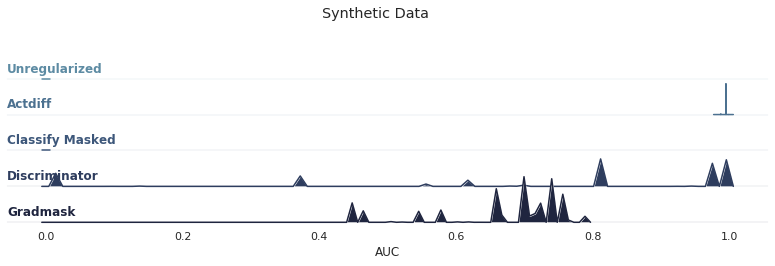

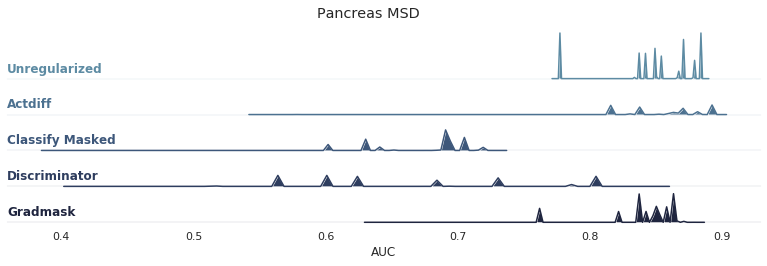

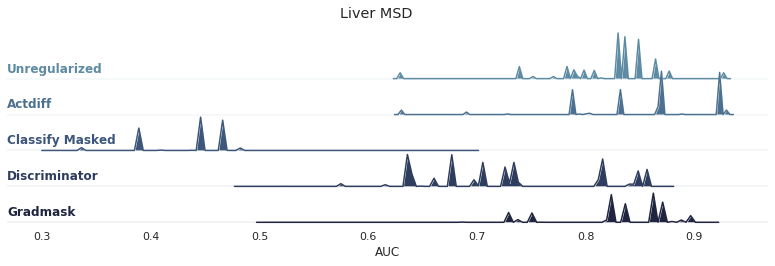

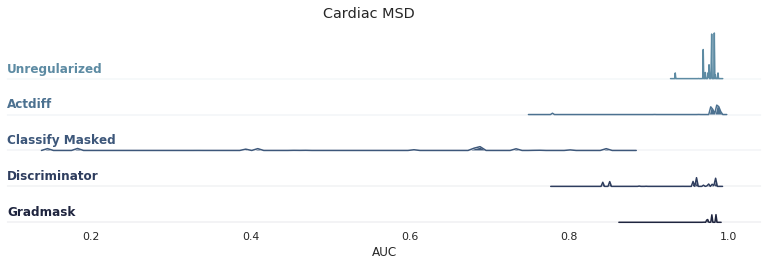

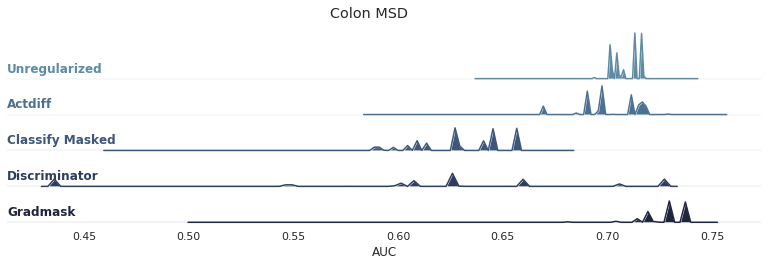

In [12]:
plot_search_space(os.path.join(RESULTS_DIR, 'synth-search'), "Synthetic Data", 1234);
plot_search_space(os.path.join(RESULTS_DIR, 'pancreasmsd-search'), "Pancreas MSD", 1234);
plot_search_space(os.path.join(RESULTS_DIR, 'livermsd-search'), "Liver MSD", 1234);
plot_search_space(os.path.join(RESULTS_DIR, 'cardiacmsd-search'), "Cardiac MSD", 1234);
plot_search_space(os.path.join(RESULTS_DIR, 'colonmsd-search'), "Colon MSD", 1234);

# Plot Test Results on Seeds

In [13]:
get_test_results(df_seeds, count=False)

,best_test_score,best_test_score_std
experiment_name,,


In [ ]:
# Synthetic Last Epoch Results.
with open('tables/synth_last_results.tex','w') as tf:
    tf.write(get_last_results_at_epoch(df_synth, EPOCH, sig_digits=2).to_latex())#

get_last_results_at_epoch(df_synth, EPOCH, sig_digits=2)

In [ ]:
# MSD Dataset Best Test Results.
with open('tables/all_test_results.tex', 'w') as tf:
    tf.write(make_results_table([df_synth, df_liver, df_cardiac, df_pancreas], sig_digits=2).to_latex())

make_results_table([df_synth, df_liver, df_cardiac, df_pancreas], sig_digits=2)

In [ ]:
# XRAY Best Test Results.
with open('tables/all_xray_results.tex', 'w') as tf:
    tf.write(make_results_table([df_xray], sig_digits=2).to_latex())

make_results_table([df_xray], sig_digits=2)

In [ ]:
# Uses the control experiments (no activmask) as the "maxmasks=0" runs for the maxmasks plots below.
#df_synth_mask = df[df['experiment_name'].str.contains('synth-masks')]
#df_synth_mask = merge_dfs_for_maxmasks(df_synth, df_synth_mask, 'synth', 'synth-masks', 10)
#df_liver_mask = df[df['experiment_name'].str.contains('livermsd-masks')]
#df_liver_mask = merge_dfs_for_maxmasks(df_liver, df_liver_mask, 'livermsd', 'livermsd-masks', 1)
#df_cardiac_mask = df[df['experiment_name'].str.contains('cardiacmsd-masks')]
#df_cardiac_mask = merge_dfs_for_maxmasks(df_cardiac, df_cardiac_mask, 'cardiacmsd', 'cardiacmsd-masks', 1)
#df_pancreas_mask = df[df['experiment_name'].str.contains('pancreasmsd-masks')]
#df_pancreas_mask = merge_dfs_for_maxmasks(df_pancreas, df_pancreas_mask, 'pancreasmsd', 'pancreasmsd-masks', 1)
#df_mask = pd.concat([df_synth_mask, df_liver_mask, df_cardiac_mask, df_pancreas_mask], axis=0)

In [ ]:
def ax_lineplot(ax, df_filter, y_min, title, legend=False):
    sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0), 'legend.frameon':True})
    
    palette = {
        '{}_resnet'.format(df_filter): "gray", 
        '{}_resnet_actdiff'.format(df_filter): "red",
        '{}_resnet_clfmasked'.format(df_filter): "green",
        '{}_resnet_gradmask'.format(df_filter): "blue",
        '{}_resnet_discriminator'.format(df_filter): "orange"
    }
    
    names = ["Experiment", "Baseline", "Actdiff", "Classify Masked", "Discriminator", "GradMask"]
    
    _df = df_experiment_filter(get_performance_metrics(results_dir), df_filter)
    g = sns.lineplot(
        x="this_epoch", y='valid_auc', hue='experiment_name', 
        ax=ax, data=_df, palette=palette, hue_order=sorted(list(palette.keys())))
    g.set_title(title)
    
    if legend:
        legend = g.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
        for t, l in zip(legend.texts, names):
            t.set_text(l)
    else:
        g.get_legend().remove()

    g.set_ylim(y_min, 1.05) 
    g.set_xlabel('Epoch')
    g.set_ylabel('Valid AUC')

    
names = [('synth-seeds', 'Synthetic', -0.05), 
         ('livermsd-seeds', 'MSD Liver', 0.45),
         ('cardiacmsd-seeds', 'MSD Cardiac', 0.45),
         ('pancreasmsd-seeds', 'MSD Pancreas', 0.45),
         ('colonmsd-seeds', 'MSD Colon', 0.45)
        ]
    
fig, axs = plt.subplots(
    figsize=(8, 12), nrows=len(names), ncols=1, sharex=True, sharey=False)

for i, ax in enumerate(axs.ravel()):
    if len(names)-1 >= i:
        # Legend only for the first plot.
        (df_filter, title, y_min) = names[i]
        ax_lineplot(ax, df_filter, y_min, title, legend=i == 0)
    else:
        ax.set_axis_off()
fig.set_tight_layout(tight=True)

# Datasets

In [ ]:
d_synth = SyntheticDataset(mode='distractor3', dataroot='/home/jdv/code/activmask/data/synth2')
d_heart = HeartMSDDataset(base_path='/srv/data/msd', mode='test', nsamples=10, blur=4)
d_liver = LiverMSDDataset(base_path='/srv/data/msd', mode='test', nsamples=1000, blur=4)
d_pancr = PancreasMSDDataset(base_path='/srv/data/msd', mode='test', nsamples=1000, blur=4)
d_xray = JointDataset(
    "/srv/data/xray/NIH/images-128",
    "/srv/data/xray/Data_Entry_2017.csv",
    "/srv/data/xray/PC/images-128",
    "/srv/data/xray/PADCHEST_chest_x_ray_images_labels_160K_01.02.19.csv",
    mode='test', seed=1234, ratio=0.9, new_size=128)


In [ ]:
def view_dataset_wrapper(blur=0, nsamples=10):
    dataset = HeartMSDDataset(
        base_path='/srv/data/msd', mode='test', nsamples=nsamples, blur=blur)
    view_dataset(dataset)

def view_dataset(dataset):
    fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(18, 18), dpi=72)
    ALPHA = 0.50
    mask_cmap = plt.cm.Reds
    mask_cmap.set_under('k', alpha=0)

    for ax, sample in zip(axs.ravel(), dataset):
        
        x, seg, y = sample

        image = torch.clone(x).detach().cpu().numpy()[0]
        mask = seg.detach().cpu().numpy()[0]
        
        ax.imshow(image, interpolation='none', cmap='Greys_r')
        if y == 1:
            ax.imshow(mask, interpolation='none', cmap=mask_cmap, clim=[0.000001, mask.max()], alpha=ALPHA)
        ax.set_title('label={}'.format(y))

view_dataset_wrapper(blur=2, nsamples=10)

# Mean Saliency Maps / Dataset-Level Stats

In [19]:
def render_mean_grad_wrapper(dataset, exp_name, title, size):
    base_mdl = load_model(os.path.join(RESULTS_DIR, "{}_resnet/{}".format(exp_name, BEST_MODEL_NAME)))
    disc_mdl = load_model(os.path.join(RESULTS_DIR, "{}_resnet_discriminator/{}".format(exp_name, BEST_MODEL_NAME)))
    actd_mdl = load_model(os.path.join(RESULTS_DIR, "{}_resnet_actdiff/{}".format(exp_name, BEST_MODEL_NAME)))
    grad_mdl = load_model(os.path.join(RESULTS_DIR, "{}_resnet_gradmask/{}".format(exp_name,BEST_MODEL_NAME)))
    render_mean_grad(dataset, base_mdl, disc_mdl, actd_mdl, grad_mdl, title, img_size=size)


def render_mean_grad(dataset, mdl_base, mdl_disc, mdl_actd, mdl_grad, 
                     exp_name, img_size=100, verbose=False):
    """
    Renders the mean saliency map across all inputs in the dataset, from the
    input models for visual comparison.
    """
    
    ALPHA = 0.50
    GRADMASK_THRESHOLD = 9
    
    fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18, 12), dpi=72)
    n = len(dataset)
    
    images, models = OrderedDict(), OrderedDict()
    names = ["Masked Image", "Mask", "Baseline", "Discriminator", "Actdiff", "Gradmask"]
    for name in names:
        images[name] = np.zeros((img_size, img_size))   
    models['Baseline'] = mdl_base
    models['Discriminator'] = mdl_disc
    models['Actdiff'] = mdl_actd 
    models['Gradmask'] = mdl_grad
            
    def _get_gradmask(x, y_pred):
        """Gradmask wrapper: returns abs value in numpy format."""
        # Removes channel dimension, batch dimension.
        if len(y_pred.shape) == 1:
            y_pred = y_pred.unsqueeze(0)  # Add batch dimension back.
        gradmask = np.abs(get_grad_contrast(x, y_pred).detach().cpu().numpy()[0][0])
        gradmask *= (gradmask > np.percentile(gradmask, GRADMASK_THRESHOLD))

        return gradmask
    
    for sample in dataset:
        
        x, seg, y = sample

        # Only plot the positive cases.
        if y == 0:
            continue
        
        images["Masked Image"] += torch.clone(x).detach().cpu().numpy()[0]
        images["Mask"] += seg.detach().cpu().numpy()[0]
        
        # Add the gradients for each model.
        for model_name, model in models.items():
            x_var = torch.autograd.Variable(torch.clone(x).unsqueeze(0), requires_grad=True)
            outputs = model(x_var, seg)
            images[model_name] += _get_gradmask(x_var, outputs['y_pred'])
            
            if verbose:
                print('{} correct? {}'.format(
                    model_name, 
                    y == torch.argmax(outputs['y_pred']).detach().cpu().numpy()))
    
    
    gradient_cmap = plt.cm.jet
    gradient_cmap.set_under('k', alpha=0)

    axs = axs.ravel()
    for i, (name, image) in enumerate(images.items()):
        image /= n  # Normalize by dataset size.
        axs[i].set_title(name, size=24)
        if 'Mask' in name:
            axs[i].imshow(image, interpolation='none', cmap='Greys_r')
        else:
            # Plot gradients with image as background.
            axs[i].imshow(images["Masked Image"], interpolation='none', cmap='Greys_r')
            axs[i].imshow(image, interpolation='none', cmap=gradient_cmap, 
                          clim=[0.000001, image.max()], alpha=ALPHA)
        axs[i].axis('off')

    plt.tight_layout()
    plt.show()


NSAMPLES = 20

This test dataloader contains: Counter({True: 10, False: 10})


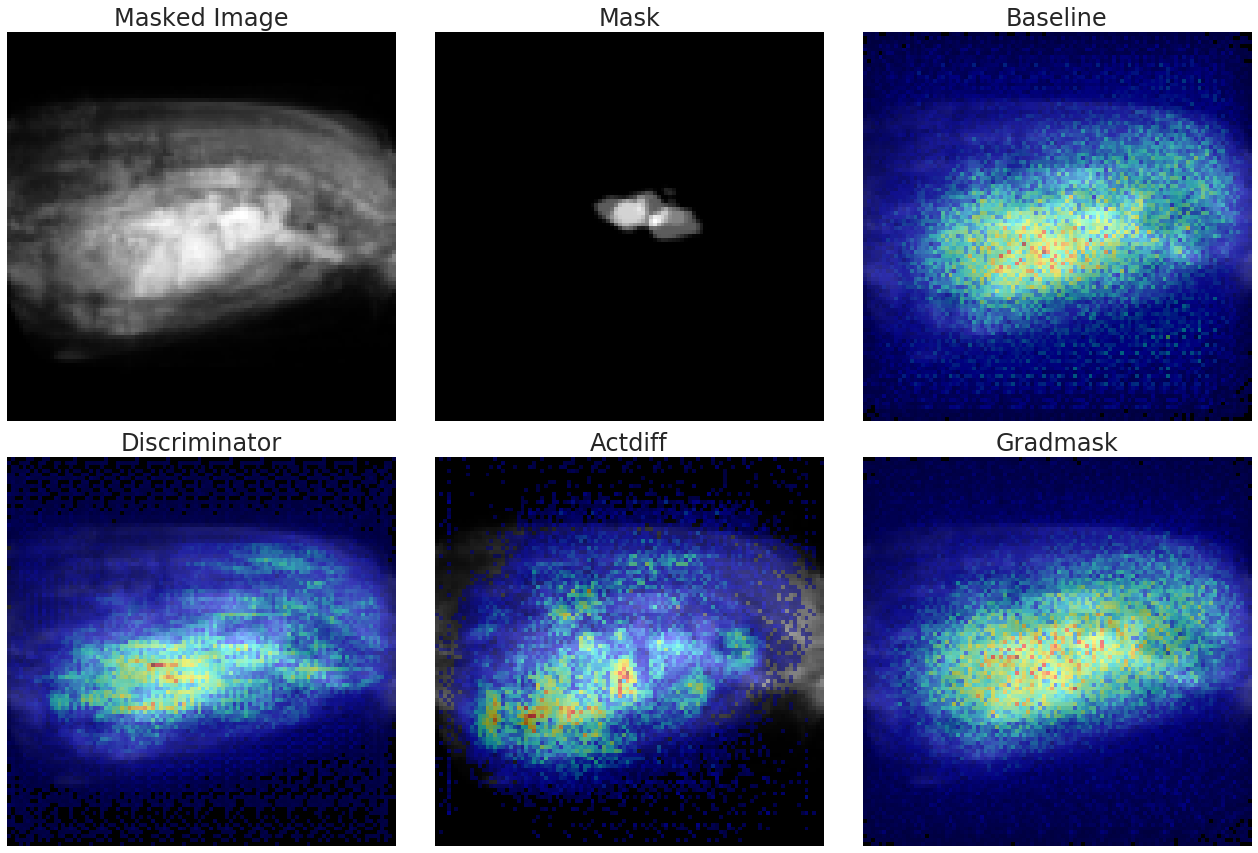

In [20]:
dataset = HeartMSDDataset(
    base_path='/srv/data/msd', mode='test', nsamples=NSAMPLES, blur=0)
render_mean_grad_wrapper(dataset, 'cardiacmsd-search', 'MSD Cardiac', size=100)

This test dataloader contains: Counter({True: 10, False: 10})


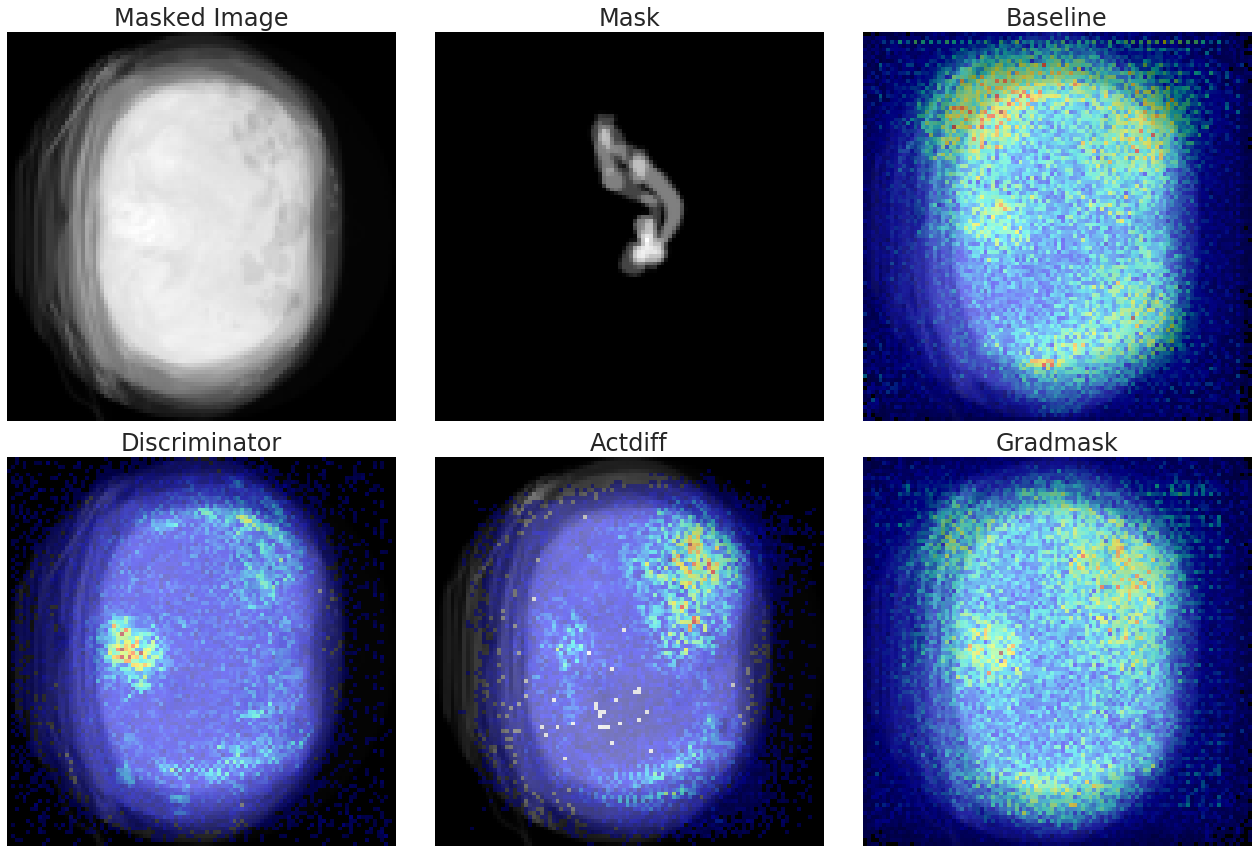

In [21]:
dataset = PancreasMSDDataset(
    base_path='/srv/data/msd', mode='test', nsamples=NSAMPLES)#, blur=16)
render_mean_grad_wrapper(dataset, 'pancreasmsd-search', 'MSD Pancreas', size=100)

This test dataloader contains: Counter({True: 10, False: 10})


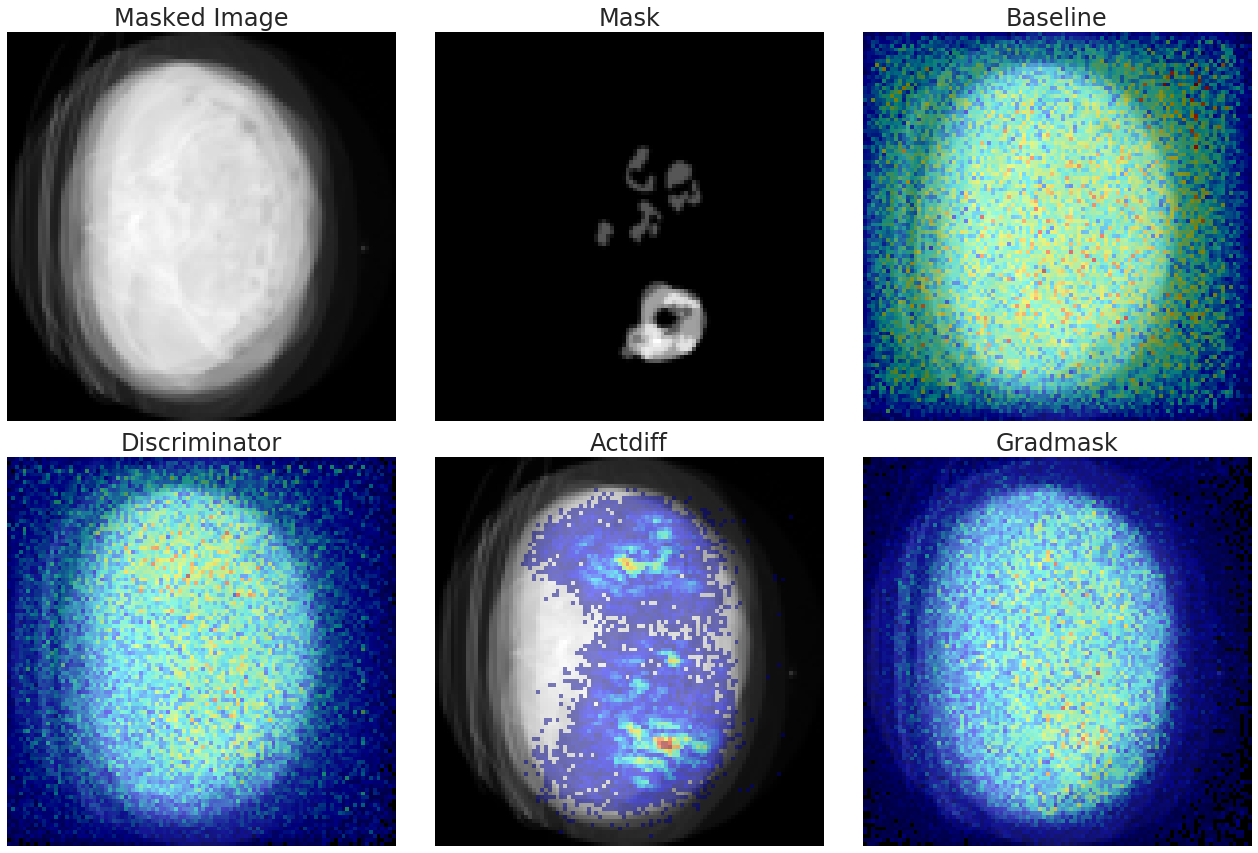

In [22]:
dataset = ColonMSDDataset(
    base_path='/srv/data/msd', mode='test', nsamples=NSAMPLES)#, blur=16)
render_mean_grad_wrapper(dataset, 'colonmsd-search', 'MSD Colon', size=100)

This test dataloader contains: Counter({True: 10, False: 10})


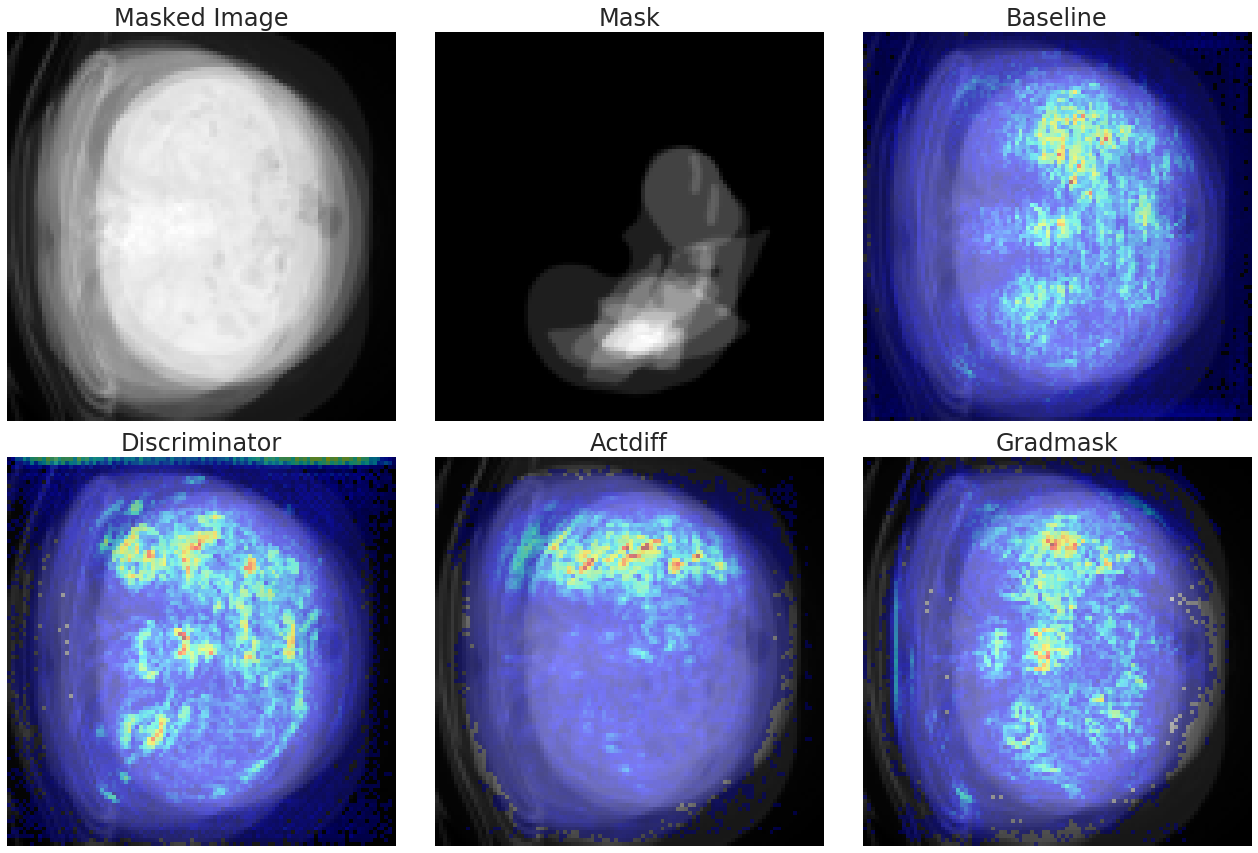

In [17]:
dataset = LiverMSDDataset(
    base_path='/srv/data/msd', mode='test', blur=0, nsamples=NSAMPLES)
render_mean_grad_wrapper(dataset, 'livermsd-search', 'MSD Liver', size=100)

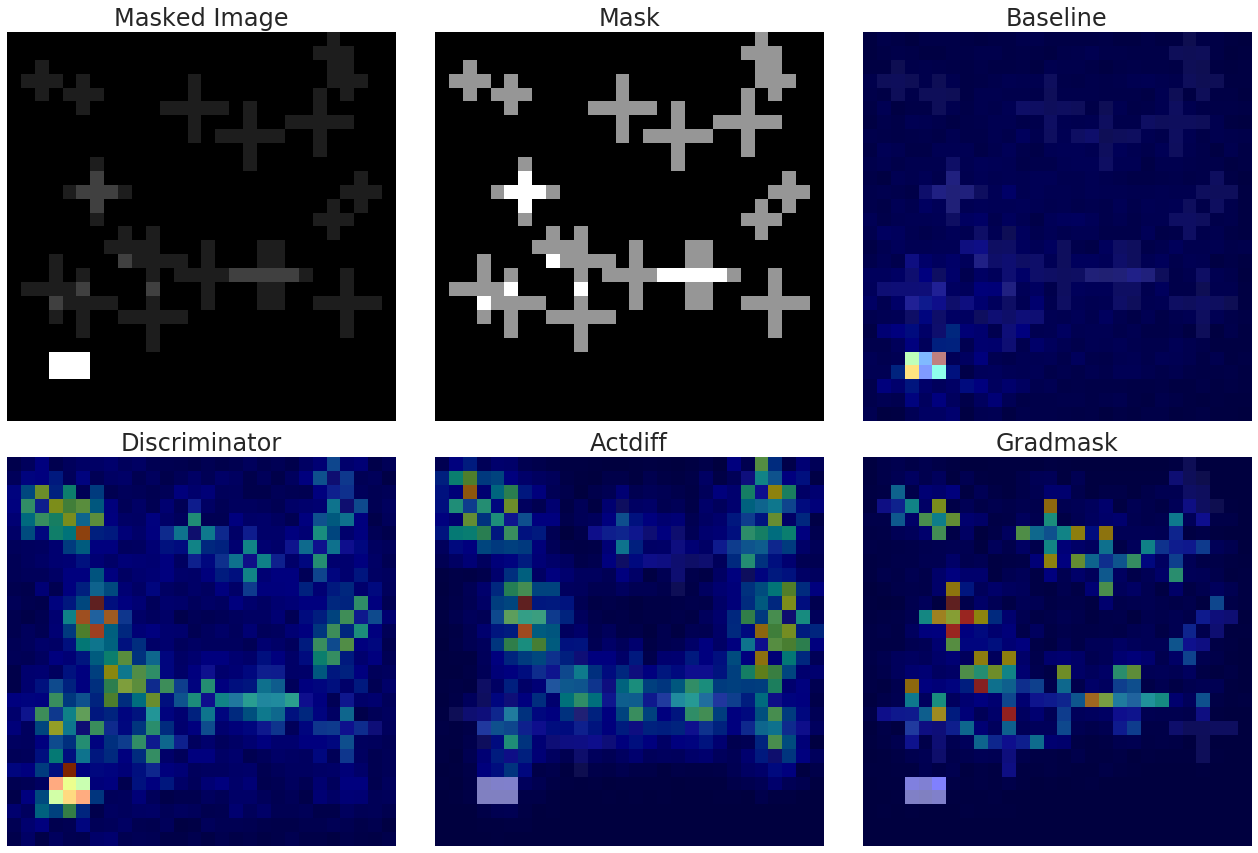

In [23]:
dataset = SyntheticDataset(
    dataroot="/home/jdv/code/activmask/data/synth2",
    mode='distractor3',
    distract_noise=1, 
    nsamples=NSAMPLES)
render_mean_grad_wrapper(dataset, 'synth-search', 'Synthetic', size=28)